In [10]:
# ************************
# モデル構築(CNN)  *******
# ************************

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np

# 乱数固定 ----------
import keras.backend as K
import tensorflow as tf

np.random.seed(seed=0)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# 画像ファイルパス ----------
train_data_dir = "data/train/" # training dir path
validation_data_dir = "data/validation/" # validation dir path

# モデル条件設定 ----------
img_width, img_height = 150, 150 # モデル画像サイズ
nb_train_samples = 282 # training data (1500x2)
nb_validation_samples = 276 # validation data (500x2)  ※兵　フォルダからファイルの数読み入れるように改造
epochs = 50 # エポック数
batch_size = 30 # バッチ数
nb_category = 2 # カテゴリ数（ok, ng）

# 画像データのジェネレータ ----------

# 訓練用
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")
# 検証用
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

# モデル定義 ----------

# モデルVGG16（not include Top）
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# モデルTop
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_category, activation='softmax'))

# vgg16とtop_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# layer14までの重みパメータを固定する（訓練で更新しない）
for layer in model.layers[:15]:
    layer.trainable = False

# コールバック

# early_stopping_cb = EarlyStopping(
#    monitor='val_acc', patience=10, verbose=1, mode='max')

# checkpoint_cb = ModelCheckpoint(
#    './{epoch:03d}-{val_acc:.5f}.hdf5', save_best_only=True)

csvlogger_cb = CSVLogger('./history.csv') 

# コンパイル ----------
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.rmsprop(lr=5e-7, decay=5e-5),
              metrics=['accuracy'])

model.summary()

Found 282 images belonging to 2 classes.
Found 276 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

In [11]:
# *******************
# 訓練実行  *********
# *******************

history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=[csvlogger_cb])

# モデルを保存
model.save("model.h5")

Epoch 1/50
9/9 [==============================] - 531s 59s/step - loss: 1.1200 - acc: 0.4333 - val_loss: 1.0359 - val_acc: 0.4889
Epoch 2/50
9/9 [==============================] - 396s 44s/step - loss: 1.0384 - acc: 0.4676 - val_loss: 0.9846 - val_acc: 0.5163
Epoch 3/50
9/9 [==============================] - 397s 44s/step - loss: 0.9542 - acc: 0.5025 - val_loss: 0.9335 - val_acc: 0.4959
Epoch 4/50
9/9 [==============================] - 334s 37s/step - loss: 0.9921 - acc: 0.4789 - val_loss: 0.8794 - val_acc: 0.5772
Epoch 5/50
9/9 [==============================] - 326s 36s/step - loss: 0.9009 - acc: 0.5460 - val_loss: 0.8428 - val_acc: 0.5772
Epoch 6/50
9/9 [==============================] - 363s 40s/step - loss: 0.8573 - acc: 0.5348 - val_loss: 0.8152 - val_acc: 0.5813
Epoch 7/50
9/9 [==============================] - 358s 40s/step - loss: 0.9108 - acc: 0.5336 - val_loss: 0.8471 - val_acc: 0.5528
Epoch 8/50
9/9 [==============================] - 401s 45s/step - loss: 0.7949 - acc: 0.63

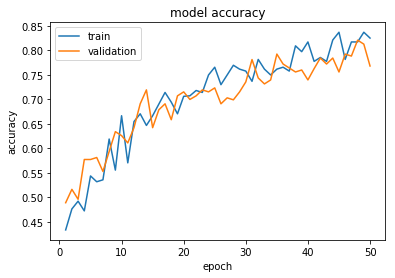

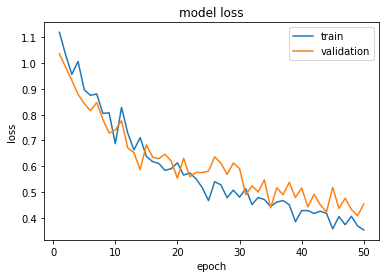

In [12]:
# *******************************
# 訓練履歴をグラフで可視化  *****
# *******************************

import matplotlib.pyplot as plt
import pandas as pd

history = pd.read_csv('history.csv')
history_rows = len(history)

# accuracy
plt.plot(range(1, history_rows + 1), history['acc']) # training
plt.plot(range(1, history_rows + 1), history['val_acc']) # validation
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# loss
plt.plot(range(1, history_rows + 1), history['loss'])
plt.plot(range(1, history_rows + 1), history['val_loss'])
plt.title('model accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [1]:
### テストデータを使って評価
# モデル読み込み（＠保存ファイルより再読み込み用）
from keras.models import load_model
model = load_model("./model.h5")

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential, load_model
import pandas as pd
import numpy as np
import os

# ****************************
# テストデータで予測実行 *****
# ****************************

test_data_dir = "data/test/" # テスト用データdir
img_width, img_height = 150, 150 # 画像サイズ（訓練同）
nb_test_samples = 14# 画像データ数　　※兵　ファルダからファイルの数自動で読み込ませるように改造
batch_size = 3 # バッチサイズ      ※兵　バッチサイズ１にすると判定がおかしくなり、camもエラーでる
nb_category = 2 # カテゴリ数（cat, dog）

# 画像データのジェネレータ（テスト用）
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# 分類予測
pred = model.predict_generator(
        test_generator,
        steps=nb_test_samples,
        verbose=1)

Found 20 images belonging to 1 classes.
14/14 [==============================] - 24s 2s/step


In [7]:
# ****************************
# テストデータの予測結果 *****
# ****************************

labels = ['ng', 'ok']
# データ0～14 -> Cat画像
# データ15～29 -> Dog画像

print("*** test data [ng] *****")
for i in pred[0:15]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

print("-" * 30)

print("*** test data [ok] *****")
for i in pred[15:21]:
    cls = np.argmax(i)
    score = np.max(i)
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

*** test data [ng] *****
pred: ok  score = 0.600
pred: ok  score = 0.534
pred: ok  score = 0.856
pred: ok  score = 0.869
pred: ok  score = 0.706
pred: ng  score = 0.795
pred: ok  score = 0.544
pred: ok  score = 0.589
pred: ng  score = 0.766
pred: ng  score = 0.524
pred: ok  score = 0.666
pred: ng  score = 0.748
pred: ng  score = 0.721
pred: ok  score = 0.526
pred: ok  score = 0.600
------------------------------
*** test data [ok] *****
pred: ok  score = 0.534
pred: ok  score = 0.856
pred: ok  score = 0.869
pred: ok  score = 0.706
pred: ng  score = 0.795
pred: ok  score = 0.544


In [3]:
#################################
# grad-cam 呼び出し用関数
#################################
import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1) # set learning phase

# *************************************************
# Gradient-weighted Class Activation Mapping  *****
#**************************************************

# 呼び出し用関数
def Grad_Cam(input_model, x, layer_name):

    # 前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # 予測クラス算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    #  勾配取得
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重み平均化、cam算出
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # ヒートマップ合成
    w = x.shape[0]
    h = x.shape[1]
    cam = cv2.resize(cam, (w, h), cv2.INTER_LINEAR)
    
    cam = np.maximum(cam, 0)
    if cam.max() == 0: # 色付け不可（ブルー画像になる）
      return None
    
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)
    jetcam = (np.float32(jetcam) + x / 2)

    return jetcam


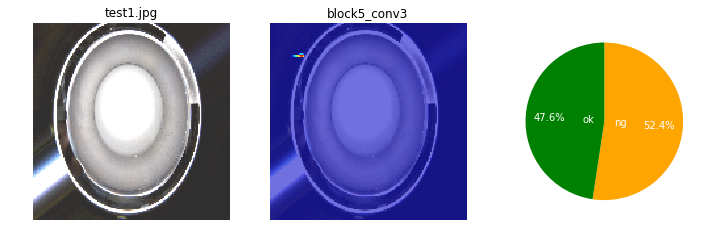

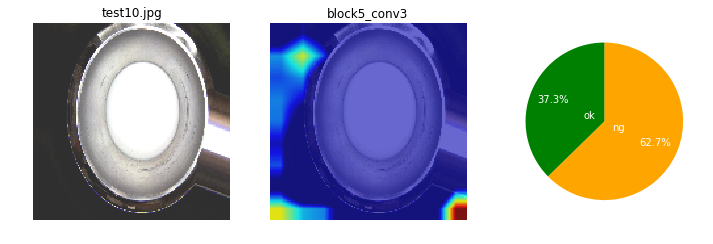

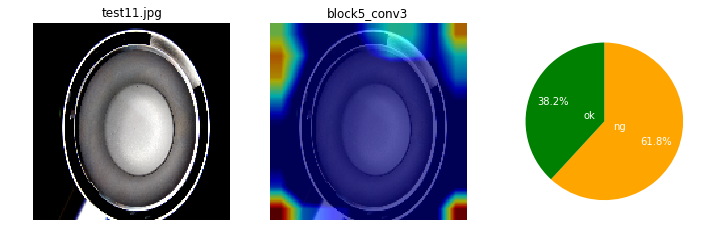

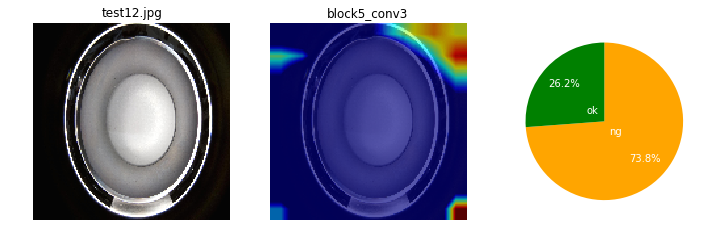

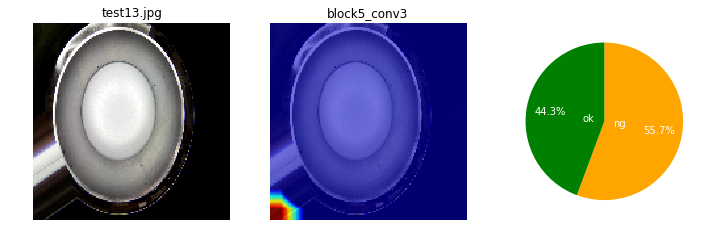

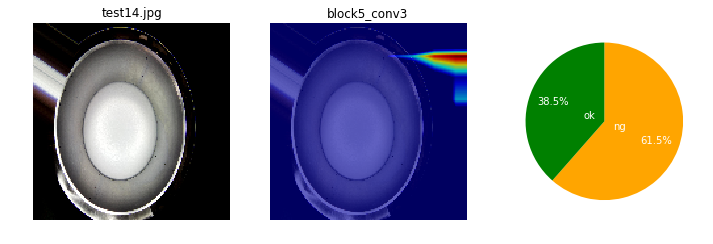

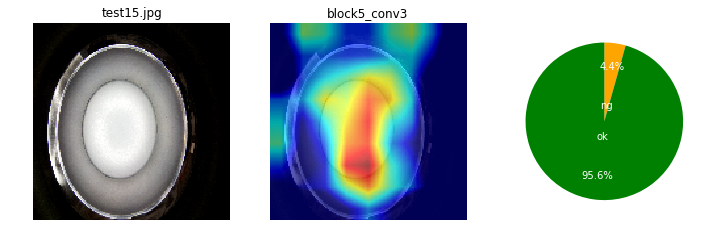

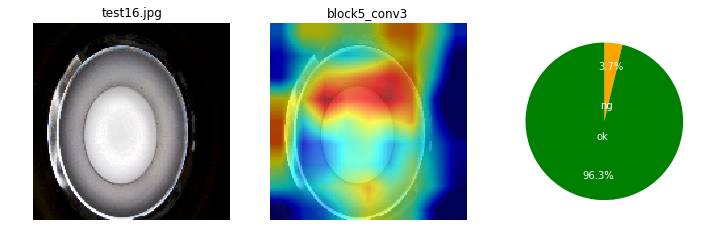

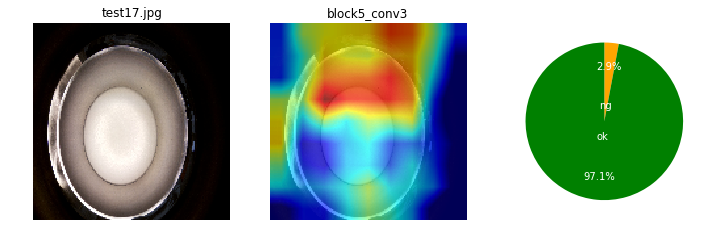

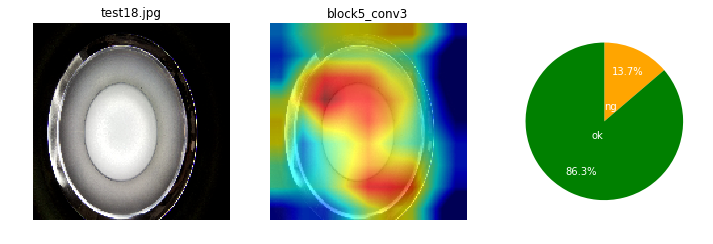

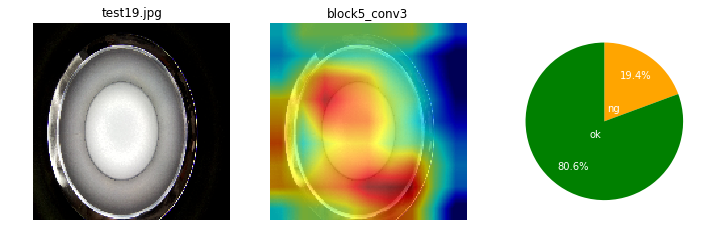

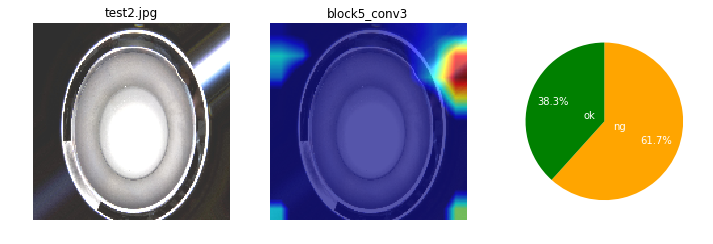

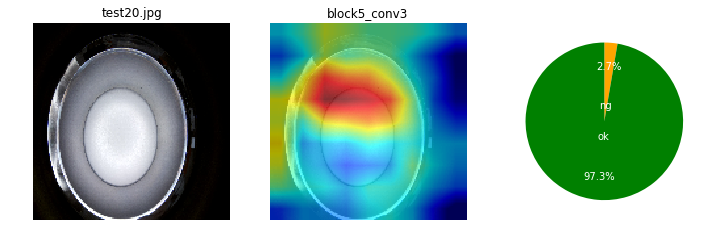

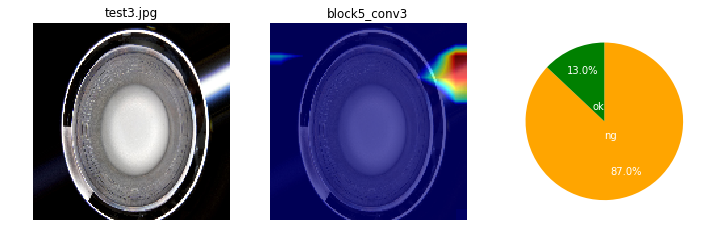

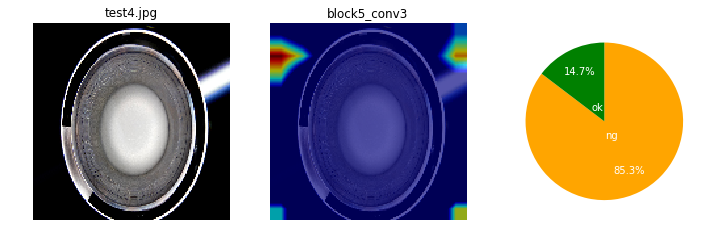

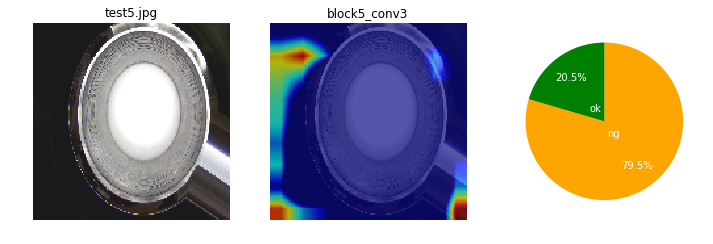

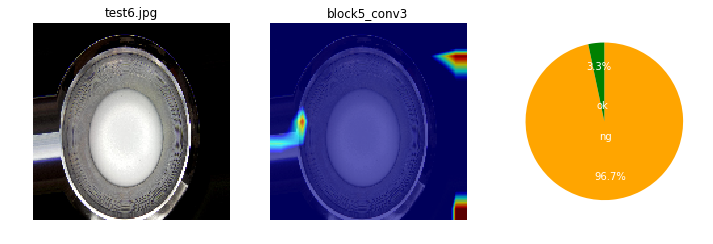

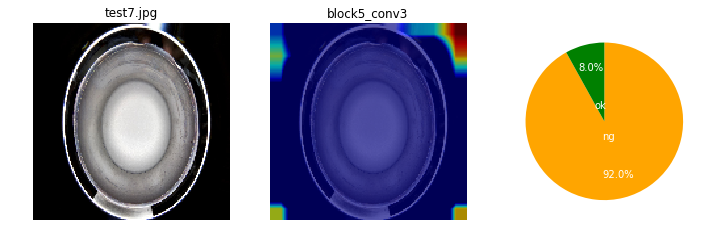

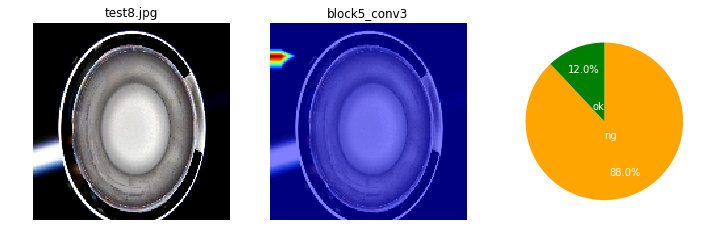

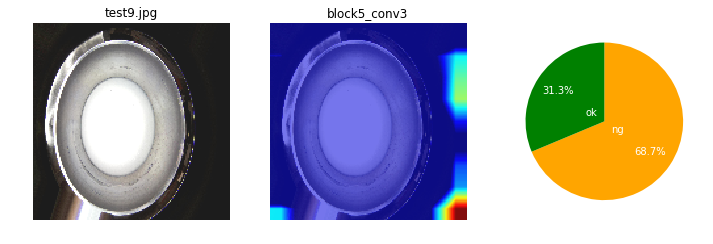

In [5]:
import os
import glob
import matplotlib.pyplot as plt

# *****************************************************
# Grad Camで色付けして可視化(テストデータで実行) ******
# *****************************************************

labels = ['ng', 'ok']
test_dir = 'data/test' # テスト画像dir
# （正解ラベルなしを仮定してunknowディレクトに保存した）

test_files = sorted(glob.glob(os.path.join(test_dir, '*', '*.jpg')))

test_data_count = len(test_files)

for idx in range(test_data_count):
  
    file = test_files[idx] # file path (試しで30データ)
    file_name = os.path.basename(file)
    img_original = load_img(file, target_size=(150,150))

    # grad cam
    arr = img_to_array(img_original)
    layer_name = 'block5_conv3' # 最後の畳み込み層
    grad_cam = Grad_Cam(model, arr, layer_name) # grad_cam呼び出し
    
    if grad_cam is None:
        layer_name = 'block5_conv2' # 最後のひとつ前の畳み込み層（ラストがダメな場合）
        grad_cam = Grad_Cam(model, arr, layer_name)   
    img_grad_cam = array_to_img(grad_cam)

    # 画像表示
    fig = plt.figure(figsize=(12, 4))

    # Image Original 
    fig.add_subplot(1, 3, 1)
    plt.imshow(img_original)
    plt.title(file_name)
    plt.axis('off')

    # Image Grad-Cam
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_grad_cam)
    plt.title(layer_name)
    plt.axis('off')

    # Pie Graph prediction score
    data_pred = pred[idx]

    colors = ["orange", "green"] # pred dog

    fig.add_subplot(1, 3, 3)
    plt.pie(data_pred,
            labels=labels,
            colors=colors,
            counterclock=False,
            startangle=90,
            labeldistance=0.2,
            autopct="%.1f%%",
            pctdistance=0.7,
            textprops={'color': 'white', 'horizontalalignment':'center'})

    plt.show()


